In [1]:
import os
import fastmri
from fastmri.data import transforms
import numpy as np
import torch
import pytorch_lightning as pl
import PIL
import pandas as pd
import h5py
from matplotlib import pyplot as plt
import nibabel as nib
import pydicom

%matplotlib inline

In [36]:
base_folder = "/data/projects/dwi_aisd/dicoms"
file_names = os.listdir(base_folder)
output_dir = "/data/projects/dwi_aisd/DWIs_nii/"

In [63]:
import dicom2nifti

for dicom_id in file_names:
    in_dir = os.path.join(base_folder, dicom_id, "DWI")
    dicom_files = os.listdir(in_dir)
    out_name = os.path.join(output_dir, dicom_id + "_DWI" + ".nii.gz")
    if os.path.isfile(out_name):
        continue
    if not os.path.isfile(os.path.join(in_dir, dicom_files[0])):
        for i in dicom_files:
            in_dir = os.path.join(base_folder, dicom_id, "DWI", i)
            out_name = os.path.join(output_dir, dicom_id + "_" + i + "_DWI" + ".nii.gz")
            if os.path.isfile(out_name):
                continue
            dicom2nifti.dicom_series_to_nifti(in_dir, out_name, reorient_nifti=False)
    else:
        dicom2nifti.dicom_series_to_nifti(in_dir, out_name, reorient_nifti=False)

In [64]:
from scipy.stats import entropy as sci_entropy
def entropy(array, base=2):
    value, counts = np.unique(array, return_counts=True)
    return sci_entropy(counts, base=base)

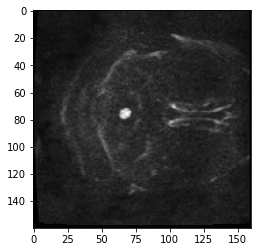

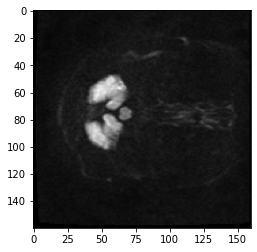

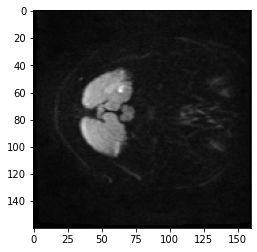

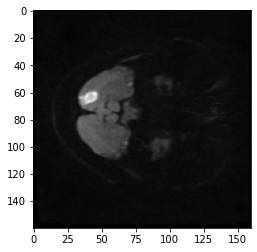

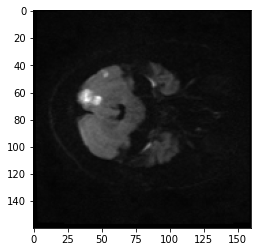

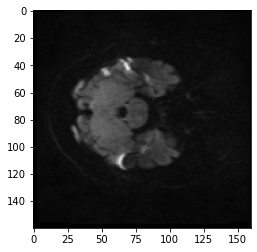

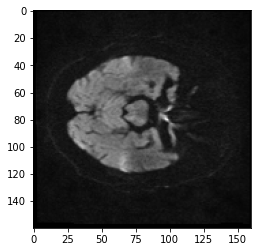

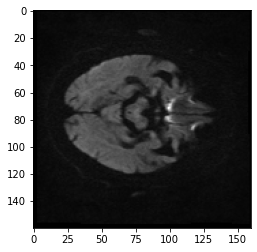

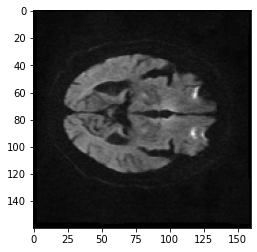

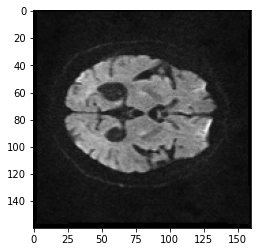

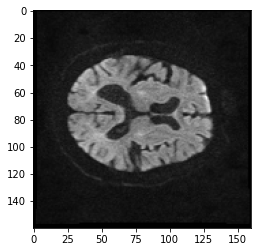

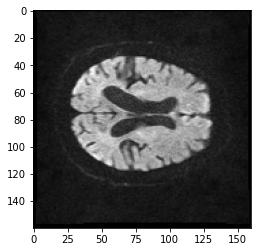

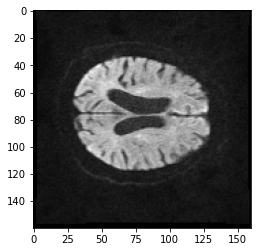

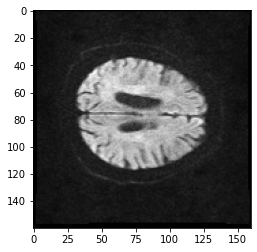

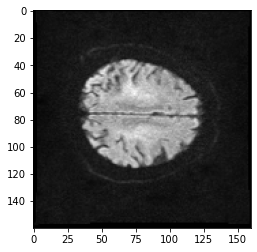

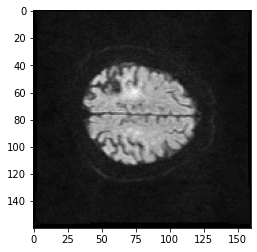

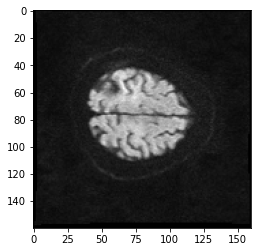

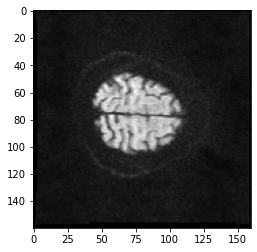

In [40]:
nii_file_path = "/data/projects/dwi_aisd/DWIs_nii/0019983_DWI.nii.gz"
nii = nib.load(nii_file_path)
nii = nib.as_closest_canonical(nii)
nii_numpy = np.array(nii.dataobj)
transform = np.array(nib.load(nii_file_path).affine)
# nii_numpy = nii_numpy[:, :, :, 0]
for i in range(nii_numpy.shape[-1]):
    plt.imshow(nii_numpy[:, :, i], cmap="gray")
    plt.show()

(512, 512, 17)
0.0 0.20665069947759784 1.0


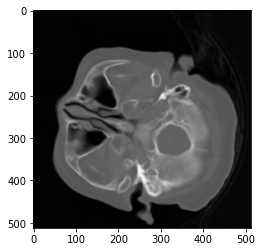

0.0 0.21508874764077796 1.0


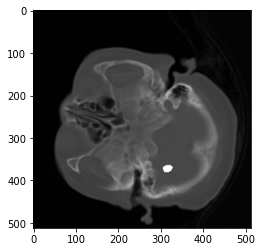

0.0 0.19608420663144321 1.0


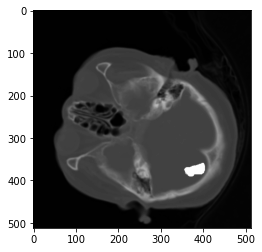

0.0 0.21771877145027108 1.0


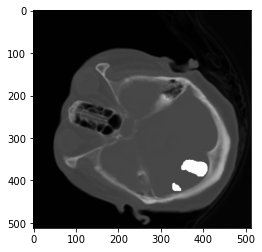

0.0 0.22403114652794215 1.0


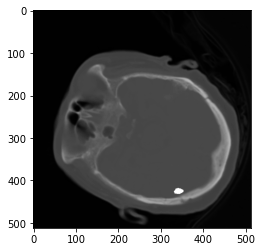

0.0 0.230916638240636 1.0


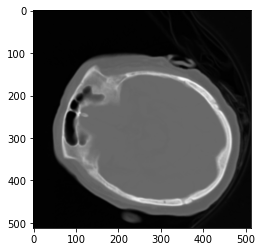

0.0 0.2269276658755366 1.0


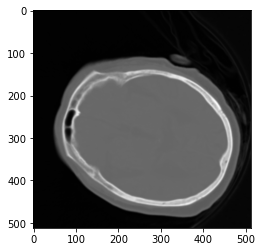

0.0 0.22045692073488693 1.0


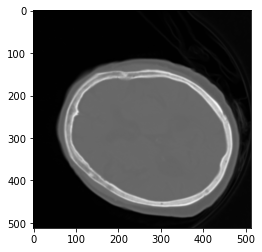

0.0 0.22681945825501848 1.0


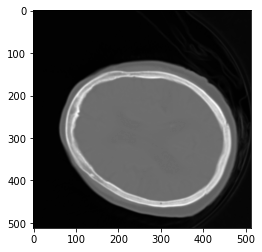

0.0 0.22106238374492634 1.0


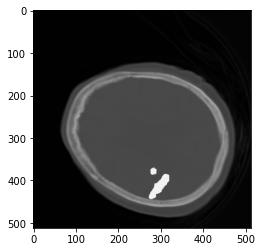

0.0 0.21109203479793215 1.0


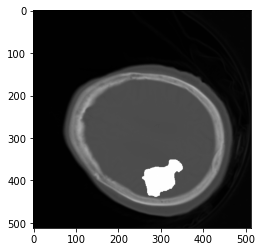

0.0 0.20582491964907257 1.0


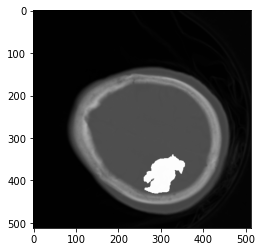

0.0 0.19751425088788363 1.0


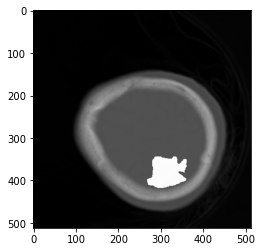

0.0 0.17930175760433098 1.0


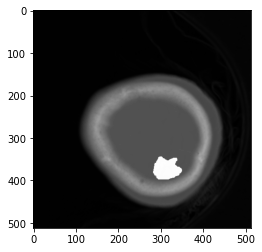

0.0 0.15720365812193673 1.0


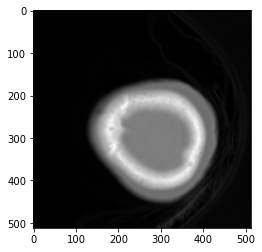

0.0 0.11588837943687569 1.0


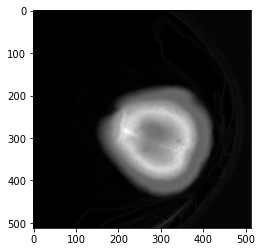

0.0 0.08770266802942166 1.0


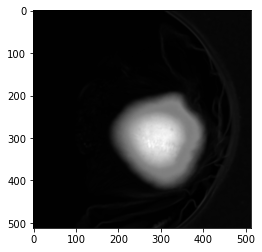

In [41]:
ct_file_path = "/data/projects/dwi_aisd/CTs_laura/0019983_CT.nii.gz"
mask_file_path = "/data/projects/dwi_aisd/Masks_laura/0019983_mask.nii.gz"
ct = nib.load(ct_file_path)
nicti = nib.as_closest_canonical(ct)
ct_numpy = np.array(ct.dataobj)
mask_numpy = np.array(nib.load(mask_file_path).dataobj)
print(ct_numpy.shape)
for i in range(17):
    ct = ct_numpy[:, :, i]
    ct = (ct - ct.mean())/ct.std()
    ct -= np.min(ct)
    ct = np.divide(ct, np.max(ct))
    print(np.min(ct), np.mean(ct), np.max(ct))
    mask = mask_numpy[:, :, i]/(max(1, np.max(mask_numpy[:, :, i])))
    plt.imshow(ct + mask, cmap="gray")
    plt.show()

In [89]:
import itk
from itkwidgets import view, compare, checkerboard

def read_nii(nii_path, index=0, retain_rotation=False, canonical_alignment=True, scale=True, norm=False, low_thresh=None, high_thresh=None):
    image = itk.imread(nii_path)
    array = nib.load(nii_path)

    split = nii_path.split('/')
    split = split[-1].split('_')
    dicom_id = split[0]
    nii_type = split[-1].split('.')[0]

    if dicom_id == "0073465":
        canonical_alignment = False

    if canonical_alignment:
        array = nib.as_closest_canonical(array)
    array = np.array(array.dataobj).astype(np.float32)
    if len(array.shape) == 4:
        array = array[:, :, :, index]

    assert array.shape[0] == array.shape[1]

    # array[array < 0] = 0

    if low_thresh is not None:
        if isinstance(low_thresh, bool):
            low_thresh = np.mean(array) - (np.std(array)/2)
        
        array[array < low_thresh] = 0

    if high_thresh is not None:
        if isinstance(high_thresh, bool):
            high_thresh = np.mean(array) + (np.std(array)/2)
        array[array > high_thresh] = 0

    if scale:
        array -= np.min(array)
        array = array/np.max(array)

    if norm:
        array = (array - array.mean())/array.std()

    # print(entropy(array))

    array = itk.image_view_from_array(array)
    spacing = itk.spacing(image)
    array.SetSpacing([spacing[0], spacing[1], spacing[2]])

    assert itk.size(array)[0] == itk.size(array)[1]

    if retain_rotation and len(itk.array_from_image(image).shape) == 3:
        direction = image.GetDirection()
        array.SetDirection(direction)

    return array

def read_png_seq(png_path):
    png_masks = os.listdir(png_path)
    png_masks.sort()

    path_split = png_path.split("/")
    path_split[4] = "CTs_laura"
    path_split[5] = path_split[5] + "_CT.nii.gz"
    CT_path = '/'.join(path_split)
    CT_image = itk.imread(CT_path)

    print(itk.size(CT_image))

    array = np.zeros((512, 512, len(png_masks)))
    for i, png_mask in enumerate(png_masks):
        png_mask_path = os.path.join(png_path, png_mask)
        array[:, :, i] = np.asarray(PIL.Image.open(png_mask_path))

    array = itk.image_from_array(array)
    spacing = itk.spacing(CT_image)
    array.SetSpacing([spacing[0], spacing[1], spacing[2]])
    return array

def register_image_mask(fixed_image_file_path, moving_image_file_path, mask_file_path, return_moving_image=False):
    fixed_image = read_nii(fixed_image_file_path, low_thresh=True, scale=True, norm=False)
    fixed_image.SetOrigin([0 for i in range(len(fixed_image.shape))])

    moving_image = read_nii(moving_image_file_path, low_thresh=0, high_thresh=100, scale=True, norm=False)
    mask = read_nii(mask_file_path, scale=False, norm=False)
    # mask = read_png_seq(mask_file_path)

    moving_image, _ = resample(moving_image, itk.size(fixed_image))
    mask, origin = resample(mask, itk.size(fixed_image), interpolator=itk.NearestNeighborInterpolateImageFunction)
    fixed_image.SetOrigin([0 for i in range(len(fixed_image.shape))])

    parameter_object = itk.ParameterObject.New()
    rigid_parameter_map = parameter_object.GetDefaultParameterMap('translation')
    parameter_object.AddParameterMap(rigid_parameter_map)
    affine_parameter_map = parameter_object.GetDefaultParameterMap('affine')
    parameter_object.AddParameterMap(affine_parameter_map)
    # bspline_parameter_map = parameter_object.GetDefaultParameterMap('bspline')
    # parameter_object.AddParameterMap(bspline_parameter_map)

    elastix_object = itk.ElastixRegistrationMethod.New(fixed_image, moving_image)
    elastix_object.SetFixedImage(fixed_image)
    elastix_object.SetMovingImage(moving_image)
    elastix_object.SetParameterObject(parameter_object)
    elastix_object.SetNumberOfThreads(8)

    elastix_object.SetLogToConsole(True)

    elastix_object.UpdateLargestPossibleRegion()

    transformed_moving_image = elastix_object.GetOutput()
    transform_parameters = elastix_object.GetTransformParameterObject()

    transformed_mask = transform_mask(mask, transform_parameters)

    if return_moving_image:
        return transformed_mask, origin, transformed_moving_image
    return transformed_mask, origin

def resample(image, output_size, remove_origin=True, interpolator=itk.BSplineInterpolateImageFunction):
    input_size = itk.size(image)
    input_spacing = itk.spacing(image)
    input_origin = itk.origin(image)

    output_size = [output_size[0], output_size[1], output_size[2]]
    output_spacing = [input_spacing[0] * (input_size[0]/output_size[0]),
                        input_spacing[1] * (input_size[1]/output_size[1]),
                        input_spacing[2] * (input_size[2]/output_size[2])]
    output_origin = [input_origin[d] + 0.5 * (output_spacing[d] - input_spacing[d]) for d in range(3)]

    interpolator = interpolator.New(image)

    image = itk.resample_image_filter(
        image,
        interpolator=interpolator,
        size=output_size,
        output_spacing=output_spacing,
        output_origin=output_origin
    )

    origin = itk.origin(image)

    if remove_origin:
        image.SetOrigin([0 for i in range(len(image.shape))])

    return image, origin

def transform_mask(mask, transform_object):
    # Load Transformix Object
    transform_object.SetParameter('FinalBSplineInterpolationOrder','0')
    transformix_object = itk.TransformixFilter.New(mask)
    transformix_object.SetTransformParameterObject(transform_object)

    # Update object (required)
    transformix_object.UpdateLargestPossibleRegion()

    # Results of Transformation
    result_image = transformix_object.GetOutput()
    return result_image


In [90]:
fixed_image_file_path = "/data/projects/dwi_aisd/DWIs_nii/0073465_DWI.nii.gz"
moving_image_file_path = "/data/projects/dwi_aisd/CTs_laura/0073465_CT.nii.gz"
mask_file_path = "/data/projects/dwi_aisd/masks_tmp/0073465_mask.nii.gz"

In [92]:
transformed_mask, origin, transformed_moving_image = register_image_mask(fixed_image_file_path,
                                                                moving_image_file_path,
                                                                mask_file_path,
                                                                return_moving_image=True)
# transformed_mask.SetOrigin(origin)
# itk.imwrite(transformed_mask.astype(itk.UC), "/data/projects/dwi_aisd/masks_DWI/0073465_mask.nii.gz")

In [85]:
compare(read_nii(fixed_image_file_path, low_thresh=True), read_nii(moving_image_file_path, low_thresh=0 , high_thresh=100))

AppLayout(children=(HBox(children=(Label(value='Link:'), Checkbox(value=False, description='cmap'), Checkbox(v…

In [86]:
compare(read_nii(fixed_image_file_path, low_thresh=True), transformed_moving_image)

AppLayout(children=(HBox(children=(Label(value='Link:'), Checkbox(value=False, description='cmap'), Checkbox(v…

In [87]:
compare(read_nii(fixed_image_file_path, low_thresh=True), transformed_mask)

AppLayout(children=(HBox(children=(Label(value='Link:'), Checkbox(value=False, description='cmap'), Checkbox(v…

In [91]:
DWI_base_folder = '/data/projects/dwi_aisd/DWIs_nii/'
CT_base_folder = '/data/projects/dwi_aisd/CTs_laura/'
mask_base_folder = '/data/projects/dwi_aisd/masks_tmp/'

mask_output_folder= '/data/projects/dwi_aisd/masks_DWI/'

dicom_ids = os.listdir(DWI_base_folder)
dicom_ids = [i[:-11] for i in dicom_ids]

for dicom_id in dicom_ids:
    dwi_path = os.path.join(DWI_base_folder, dicom_id + "_DWI.nii.gz")
    ct_path = os.path.join(CT_base_folder, dicom_id.split('_')[0] + "_CT.nii.gz")
    mask_path = os.path.join(mask_base_folder, dicom_id.split('_')[0] + "_mask.nii.gz")
    output_path = os.path.join(mask_output_folder, dicom_id + "_mask.nii.gz")

    if os.path.isfile(output_path):
        continue

    try:
        transformed_mask, origin = register_image_mask(dwi_path,
                                                ct_path,
                                                mask_path)
        transformed_mask.SetOrigin(origin)
        itk.imwrite(transformed_mask.astype(itk.UC), output_path)
    except Exception as e:
        print(f'{e}: {dicom_id} not processed.')

In [58]:
def check_masks(mask_base_dir='/data/projects/dwi_aisd/masks_DWI/'):
    files = os.listdir(mask_base_dir)
    uniques = []
    shapes = []
    for i in files:
        mask_path = os.path.join(mask_base_dir, i)
        mask = np.array(nib.load(mask_path).dataobj)
        unique = tuple(np.unique(mask))
        if len(unique) == 1:
            print(f"{i}: {unique}")
        if i == "0538549_mask.nii.gz":
            print(f"{i}: {unique}")
        shape = tuple(mask.shape)
        uniques.append(unique)
        shapes.append(shape)
    print(list(set(uniques)),list(set(shapes)))

check_masks()
check_masks('/data/projects/dwi_aisd/masks_tmp/')

0538549_2_mask.nii.gz: (0,)
[(0, 1, 3, 4), (0, 1, 2, 3, 4, 5), (0, 2, 3, 5), (0, 1, 4, 5), (0, 1, 3), (0, 1, 3, 4, 5), (0, 2), (0, 5), (0, 1, 2, 4, 5), (0, 3, 4, 5), (0, 2, 4), (0, 1, 2, 4), (0, 2, 3, 4), (0, 1, 2), (0, 3, 5), (0, 1), (0, 4), (0, 2, 4, 5), (0, 2, 3), (0, 1, 3, 5), (0, 1, 2, 3), (0, 1, 2, 3, 5), (0,), (0, 1, 4), (0, 3, 4), (0, 3), (0, 2, 5), (0, 2, 3, 4, 5), (0, 1, 2, 3, 4), (0, 4, 5), (0, 1, 2, 5)] [(256, 256, 18), (162, 162, 18), (256, 256, 30), (256, 256, 20), (192, 192, 18), (160, 160, 18)]
0538549_mask.nii.gz: (0, 3)
[(0, 1, 3, 4), (0, 1, 2, 3, 4, 5), (0, 2, 3, 5), (0, 1, 4, 5), (0, 1, 3), (0, 1, 3, 4, 5), (0, 2), (0, 5), (0, 1, 2, 4, 5), (0, 3, 4, 5), (0, 2, 4), (0, 1, 2, 4), (0, 2, 3, 4), (0, 1, 2), (0, 3, 5), (0, 1), (0, 4), (0, 2, 4, 5), (0, 2, 3), (0, 1, 3, 5), (0, 1, 2, 3), (0, 1, 2, 3, 5), (0, 1, 4), (0, 3, 4), (0, 3), (0, 2, 5), (0, 2, 3, 4, 5), (0, 1, 2, 3, 4), (0, 4, 5), (0, 1, 2, 5)] [(512, 512, 11), (512, 512, 17), (512, 512, 14), (512, 512, 20), (512, 

(192, 192, 18, 3) (192, 192, 18)


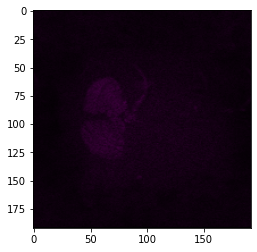

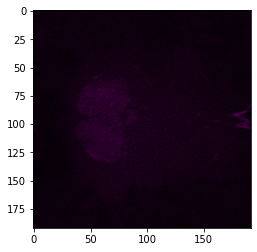

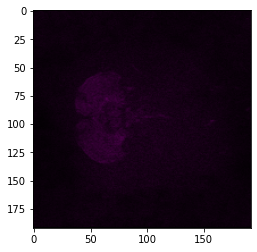

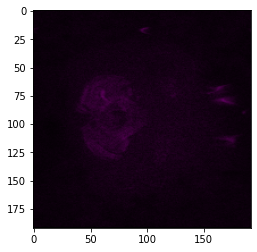

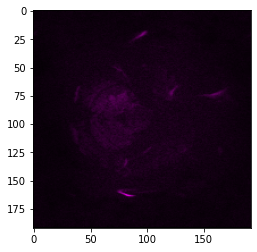

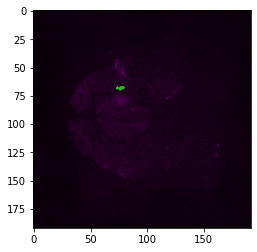

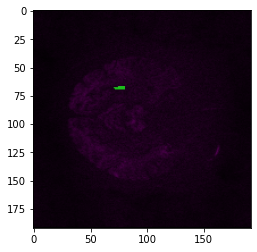

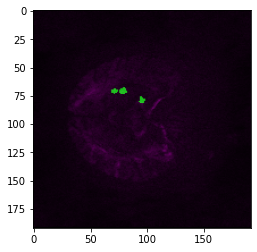

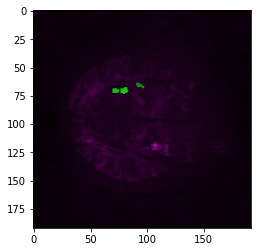

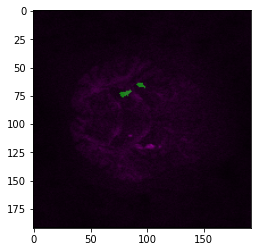

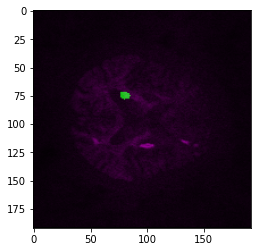

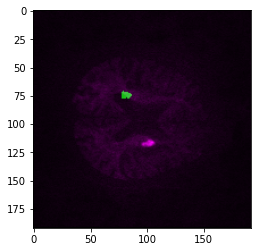

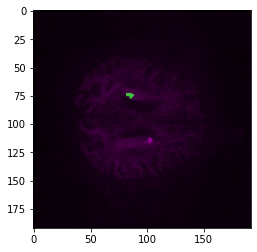

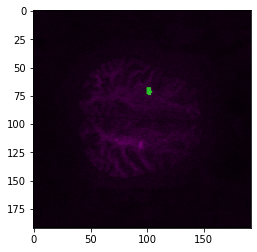

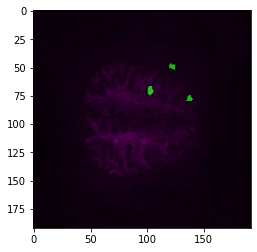

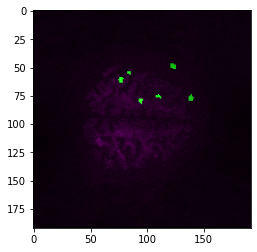

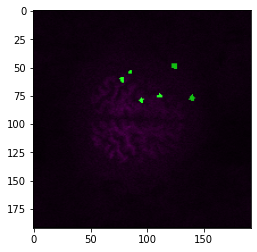

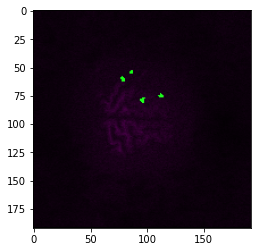

In [88]:
test = nib.load("/data/projects/dwi_aisd/DWIs_nii/0538750_3_DWI.nii.gz")
test = nib.as_closest_canonical(test)
test = np.array(test.dataobj).astype(np.float32)
test = test/np.max(test[:, :, :, 2])
trans_mask_array = nib.load("/data/projects/dwi_aisd/masks_DWI/0538750_3_mask.nii.gz")
trans_mask_array = nib.as_closest_canonical(trans_mask_array)
trans_mask_array = np.array(trans_mask_array.dataobj).astype(np.float32)
trans_mask_array = trans_mask_array/np.max(trans_mask_array)

print(test.shape, trans_mask_array.shape)

for i in range(test.shape[2]):
    image = test[:, :, i, 2]
    mask = trans_mask_array[:, :, i]

    c_img = np.zeros((image.shape[0], image.shape[1], 3))
    c_img[:, :, 0] = image
    c_img[:, :, 2] = image
    c_img[:, :, 1] = mask

    plt.imshow(c_img)
    plt.show()

In [62]:
def mask_to_nii(input_dir, output_dir):
    mask_ids = os.listdir(input_dir)
    
    for mask_id in mask_ids:
        try:
            png_path = os.path.join(input_dir, mask_id)
            png_masks = os.listdir(png_path)
            png_masks.sort()

            path_split = png_path.split("/")
            path_split[4] = "CTs_laura"
            path_split[5] = path_split[5] + "_CT.nii.gz"
            CT_path = '/'.join(path_split)
            CT_image = itk.imread(CT_path)

            array = np.zeros((len(png_masks), 512, 512), dtype=np.uint8)
            for i, png_mask in enumerate(png_masks):
                png_mask_path = os.path.join(png_path, png_mask)
                array[i, :, :] = np.asarray(PIL.Image.open(png_mask_path))

            array = itk.image_from_array(array)
            size = itk.size(CT_image)
            spacing = itk.spacing(CT_image)
            origin = itk.origin(CT_image)
            direction = CT_image.GetDirection()
            
            array.SetOrigin([origin[0], origin[1], origin[2]])
            array.SetSpacing([spacing[0], spacing[1], spacing[2]])
            array.SetDirection(direction)

            output_path = os.path.join(output_dir, mask_id + "_mask.nii.gz")
            itk.imwrite(array, output_path)
        except Exception:
            print(f"{mask_id} not found")

mask_to_nii("/data/projects/dwi_aisd/mask/", "/data/projects/dwi_aisd/masks_tmp/")

0091465 not found
0091468 not found
0091505 not found
0091519 not found
0226134 not found


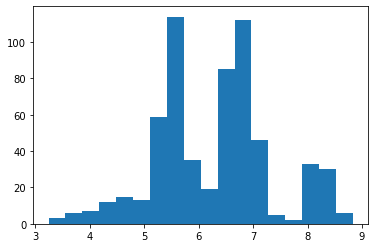

In [61]:
def plot_emtropy_histogram(data_path):
    files = os.listdir(data_path)

    hist_list = []
    for i in files:
        file_path = os.path.join(data_path, i)
        array = np.array(nib.as_closest_canonical(nib.load(file_path)).dataobj)
        if len(array.shape) == 4:
            for j in range(array.shape[-1]):
                hist_list.append(entropy(array[:, :, :, j]))
        else:
            hist_list.append(entropy(array))

    plt.hist(hist_list, bins="auto")
    plt.show()

plot_emtropy_histogram("/data/projects/dwi_aisd/DWIs_nii/")